In [1]:
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from core import derive_keys, f

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
N = 2 ** 18
alpha = [7,18,24,29]
pad = 4

def get_bit(num, pos):
    return (num >> pos) & 1

def get_bits(num, pos_list):
    res = 0
    for pos in sorted(pos_list, reverse=True):
        res = (res << 1) | get_bit(num, pos)
    return res

def merge_bits(bits_list, padding):
    res = []
    for bits in bits_list:
        bits_str = bin(bits)[2:].zfill(padding)
        bits_lst = list(map(int, bits_str))
        res.extend(bits_lst)
    return res

def generate_input_data(p, k):
    rk = derive_keys(k)
    k1, k2, k3, k4 = [next(rk) for _ in range(4)] # use 4 round keys
    
    ph, pl = p >> 32, p & 0xffffffff

    x2 = ph ^ f(pl, k1)
    x3 = pl ^ f(x2, k2)

    cl = x2 ^ f(x3, k3)
    ch = x3 ^ f(cl, k4)

    if get_bit(k2, 22) ^ get_bit(k4, 22):
        X = [
            get_bit(ph, 15), 
            get_bits(pl, alpha), 
            get_bits(ch, alpha), 
            get_bit(cl, 15), 
            get_bit(f(pl, k1), 15)
        ]
        y = 1
    else:
        X = [
            get_bit(ph, 15), 
            get_bits(pl, alpha), 
            get_bits(ch, alpha), 
            get_bit(cl, 15), 
            random.randint(0, 1)
        ]
        y = 0

    return [merge_bits(X, pad), y]

def encrypt(p, k):
    rk = derive_keys(k)
    k1, k2, k3, k4 = [next(rk) for _ in range(4)] # use 4 round keys
    
    ph, pl = p >> 32, p & 0xffffffff

    x2 = ph ^ f(pl, k1)
    x3 = pl ^ f(x2, k2)

    cl = x2 ^ f(x3, k3)
    ch = x3 ^ f(cl, k4)

    return (ch << 32) | cl

def sample():
    return random.randint(0, (1 << 64) - 1)

P = [sample() for _ in range(N)]
K = [sample() for _ in range(N)]

train_data = [generate_input_data(p, k) for p, k in zip(P, K)]
train_X = [X for X, _ in train_data]
train_y = [[y] for _, y in train_data]

train_num = N * 8 // 10
train_X, test_X = train_X[:train_num], train_X[train_num:]
train_y, test_y = train_y[:train_num], train_y[train_num:]

In [3]:
batch_size = 2 ** 10

train_tensor_X, train_tensor_y = torch.Tensor(train_X), torch.Tensor(train_y)
train_dataset = TensorDataset(train_tensor_X,train_tensor_y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_tensor_X, test_tensor_y = torch.Tensor(test_X), torch.Tensor(test_y)
test_dataset = TensorDataset(test_tensor_X,test_tensor_y)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([1024, 20])
Shape of y: torch.Size([1024, 1]) torch.float32


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

class NN(nn.Module):
	def __init__(self):
		super().__init__()
		self.layer = nn.Sequential(
			nn.Linear(20, 1024),
			nn.ReLU(),
			nn.Linear(1024, 1024),
			nn.ReLU(),
			nn.Linear(1024, 128),
			nn.ReLU(),
			nn.Linear(128, 1),
			nn.Sigmoid()
        )
	def forward(self, x):
		return self.layer(x)

model = NN().to(device)

Using cuda device


In [5]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5) == (y > 0.5)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct, test_loss


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 50.3%, Avg loss: 0.693160 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 50.3%, Avg loss: 0.693139 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 0.693091 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 50.9%, Avg loss: 0.692941 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 51.9%, Avg loss: 0.692191 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.689322 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 57.6%, Avg loss: 0.681942 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 58.7%, Avg loss: 0.676950 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 59.5%, Avg loss: 0.674749 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 59.6%, Avg loss: 0.673913 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 59.7%, Avg los

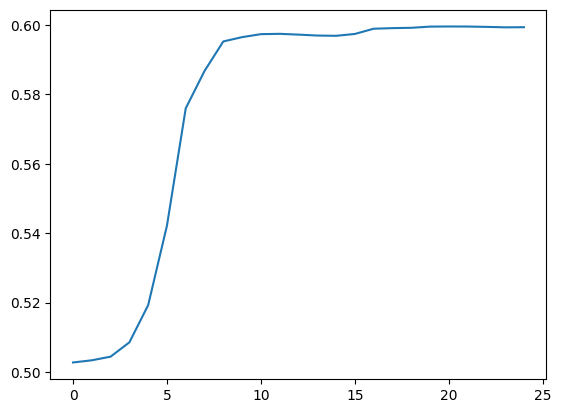

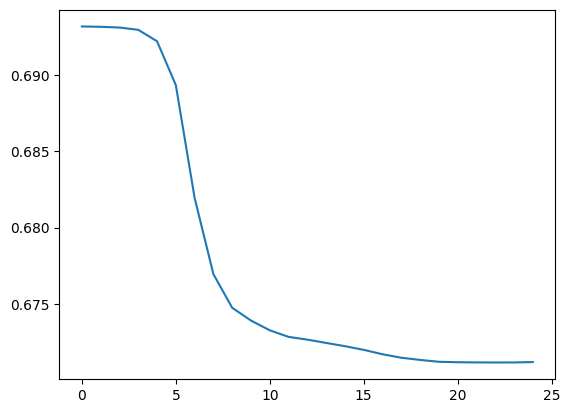

In [6]:
epochs = 25

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

acc = []
loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    acc_t, loss_t = test(test_dataloader, model, loss_fn)

    acc.append(acc_t)
    loss.append(loss_t)

plt.figure()
plt.plot(range(len(acc)), acc)
plt.savefig('acc.png')

plt.figure()
plt.plot(range(len(loss)), loss)
plt.savefig('loss.png')

In [7]:
torch.save(model.state_dict(), 'ans_model.pth')

In [8]:
def rank_key(p, c, model):
    model.eval()
    
    rank = []

    ph, pl, ch, cl = p >> 32, p & 0xffffffff, c >> 32, c & 0xffffffff
    X_part = [get_bit(ph, 15), get_bits(pl, alpha), get_bits(ch, alpha), get_bit(cl, 15)]

    for k in range(64):
        X = X_part + [get_bit(f(pl, k << 42), 15)]
        X = merge_bits(X, pad)
        X = torch.Tensor(X)
        X = X.to(device)
        pred = model(X)
        rank.append(pred.item())

    return rank

def key_check(k):
    rk = derive_keys(k)
    _, k2, _, k4 = [next(rk) for _ in range(4)]
    return get_bit(k2, 22) ^ get_bit(k4, 22)

def test(M):
    k = sample()

    P = [sample() for _ in range(M)]

    total_rank = [0 for _ in range(64)]

    for p in P:
        c = encrypt(p, k)
        for i, r in enumerate(rank_key(p, c, model)):
            total_rank[i] += r

    rk = derive_keys(k)
    k1 = next(rk)
    target = (k1 >> 42) & 0x3f
    
    prediction = total_rank.index(max(total_rank) if key_check(k) else min(total_rank))

    return target == prediction

for M in [2**5, 2**6, 2**7, 2**8]:
    cnt = 0
    for i in range(100):
        if test(M):
            cnt += 1
    print(cnt / 100)

0.49
0.76
0.97
1.0
